## Data Exploration
## Content
  * Load data 
  * Investigate SalePrice
  * Remove bad fields
  * Dealing with missing data
  * Correlation matrix for numerical features
  * Encode categorical features to numerical
  * Correlation matrix for encoded categorical features
  * Investigate Logarifm transformations
  * Investigate Pow transformations

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
from pymongo import MongoClient
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
MONGODB_URL = os.environ['KC_MONGODB_URI']
client = MongoClient(MONGODB_URL)
db = client.get_default_database()

In [3]:
data = db["train_data"].find({})
df_train = pd.DataFrame(list(data))
df_train.drop(columns=["_id"], inplace=True)
df_train.shape

(11000, 21)

In [4]:
data = db["test_data"].find({})
df_test = pd.DataFrame(list(data))
df_test.drop(columns=["_id"], inplace=True)
df_test.shape

(10613, 21)

In [5]:
full_frame = pd.concat([df_train, df_test])
full_frame.shape

(21613, 21)

## Investigate SalePrice

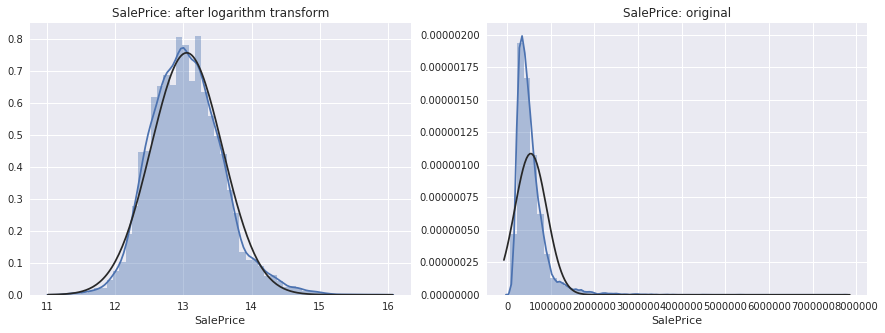

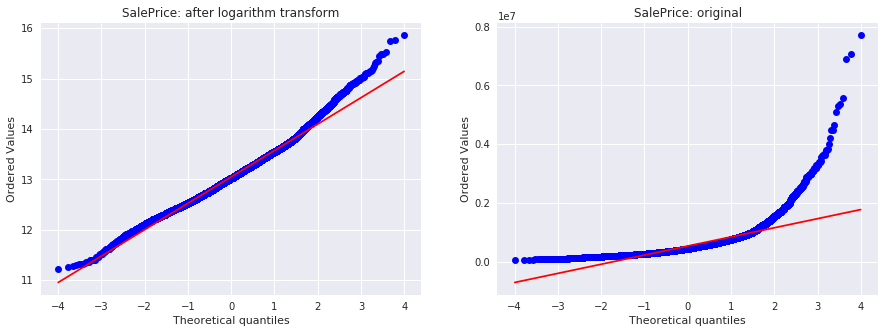

In [6]:
#histogram
sns.set(rc={'figure.figsize':(15,5)})
fig, ax = plt.subplots(1,2)
sns.distplot(np.log1p(full_frame['SalePrice']), fit=norm, ax=ax[0])
sns.distplot(full_frame['SalePrice'], fit=norm, ax=ax[1])
ax[0].set_title("SalePrice: after logarithm transform")
ax[1].set_title("SalePrice: original")
fig.show()

#normal probability plot
fig, ax = plt.subplots(1,2)
stats.probplot(np.log1p(full_frame['SalePrice']), plot=ax[0])
stats.probplot(full_frame['SalePrice'], plot=ax[1])
ax[0].set_title("SalePrice: after logarithm transform")
ax[1].set_title("SalePrice: original")
fig.show()

You should choose True value for applyLogTransformForSalePrice if after logarithm transform SalePrice became more corresponded with normal distribution

In [7]:
applyLogTransformForSalePrice = True

In [8]:
if applyLogTransformForSalePrice:
    full_frame['SalePrice'] = np.log1p(full_frame['SalePrice'])

### Remove bad fields

In [9]:
features = set(full_frame.columns.tolist())
features.remove('SalePrice')

Choose fields that cannot be taken for training for some reasons

In [10]:
# features.remove('condition')

In [11]:
len(features)

20

### Dealing with missing data

In [12]:
#missing data
total = full_frame.isnull().sum().sort_values(ascending=False)
percent = (full_frame.isnull().sum()/full_frame.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
zipcode,0,0.0
sqft_above,0,0.0
bathrooms,0,0.0
bedrooms,0,0.0
condition,0,0.0


In [13]:
# remove features where data is missed more then 5 times
features = features.difference(set((missing_data[missing_data['Total'] > 5]).index.tolist()))

In [14]:
# remove left images where data is missed
full_frame = full_frame.drop(full_frame.loc[full_frame.isnull().any(axis=1)].index)
full_frame[list(features)].isnull().sum().max() #just checking that there's no missing data missing...

0

In [15]:
# features left
len(features)

20

### Lists of numerical and categorical features

In [16]:
# get categorical features list
g = {k.name: v for k, v in full_frame[list(features)].columns.to_series().groupby(full_frame.dtypes).groups.items()}
categorical = g["object"].tolist()
numerical = g["float64"].tolist() + g["int64"].tolist()
g

{'float64': Index(['bathrooms', 'floors', 'lat', 'long'], dtype='object'),
 'int64': Index(['zipcode', 'grade', 'yr_built', 'condition', 'sqft_basement',
        'sqft_living15', 'sqft_lot15', 'sqft_lot', 'bedrooms', 'view',
        'year_sold', 'sqft_above', 'yr_renovated', 'sqft_living'],
       dtype='object'),
 'object': Index(['waterfront', 'month_sold'], dtype='object')}

### Correlation matrix for numerical features

In [17]:
# numerical features list
numerical

['bathrooms',
 'floors',
 'lat',
 'long',
 'zipcode',
 'grade',
 'yr_built',
 'condition',
 'sqft_basement',
 'sqft_living15',
 'sqft_lot15',
 'sqft_lot',
 'bedrooms',
 'view',
 'year_sold',
 'sqft_above',
 'yr_renovated',
 'sqft_living']

In [18]:
len(numerical)

18

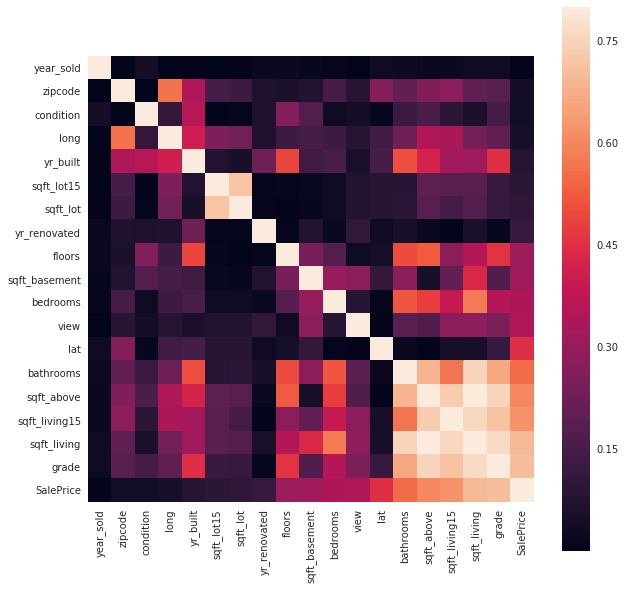

In [19]:
numerical_df = full_frame[numerical + ['SalePrice']].copy(True)

#correlation matrix
corrmat = numerical_df.corr().abs()

# sort columns in df by SalePrice correlation
cols = corrmat.sort_values(["SalePrice"])['SalePrice'].index
# get new correlation matrix with sorted columns
cm = numerical_df[cols].corr().abs()
# show plot
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(cm, vmax=.8, square=True, yticklabels=cols.values, xticklabels=cols.values)

In [20]:
# dealing with features which highly correlated with each other
# features that correlated with each other more then this threshold should be considered to remove
# Please enter threshold
thresh = 0.7

In [21]:
# mask to go through only under diagonal triangle
mask = np.ones(cm.shape,dtype='bool')
mask[np.triu_indices(len(cm))] = False

highly_corr_cm = cm.drop(index=['SalePrice'],columns=['SalePrice'])[(cm>thresh)&mask].dropna(axis=0, how='all').dropna(axis=1, how='all')
highly_corr_cm = highly_corr_cm.append(cm['SalePrice'][highly_corr_cm.columns])
highly_corr_cm['SalePrice'] = cm['SalePrice'][highly_corr_cm.index]
highly_corr_cm

,sqft_lot15,bathrooms,sqft_above,sqft_living15,sqft_living,SalePrice
sqft_lot,0.718557,NaN,NaN,NaN,NaN,0.099622
sqft_living15,NaN,NaN,0.731870,NaN,NaN,0.619312
sqft_living,NaN,0.754665,0.876597,0.756420,NaN,0.695341
grade,NaN,NaN,0.755923,0.713202,0.762704,0.703634
SalePrice,0.091592,0.550802,0.601802,0.619312,0.695341,1.000000


In [22]:
# Please enter features that should be removed according to table above 
columns_to_remove = []

In [23]:
numerical_df.drop(columns=columns_to_remove, inplace=True)

Define attributes with highest correlation and transformation type which should be applied for it. Please enter wished correlation threshold for numerical values:

In [24]:
corr_threshold_for_num_features = 0.0

In [25]:
numerical_df_log = numerical_df.copy(True)
numerical_df_log.drop(columns=['SalePrice'], inplace=True)
for feature in numerical_df_log.columns:
    numerical_df_log[feature] = numerical_df_log[feature].apply(lambda x: 0 if x <= 1 else np.log(x))
numerical_df_log["SalePrice"] = numerical_df["SalePrice"]
corrmat_log = numerical_df_log.corr().abs()


numerical_df_pow = numerical_df.copy(True)
numerical_df_pow = numerical_df_pow.drop(columns=['SalePrice']).apply(lambda x: x**2)
numerical_df_pow["SalePrice"] = numerical_df["SalePrice"]
corrmat_pow = numerical_df_pow.corr().abs()

magic_num_table = pd.DataFrame()
magic_num_table["log"] = corrmat_log["SalePrice"]
magic_num_table["pow"] = corrmat_pow["SalePrice"]
magic_num_table["origin"] = corrmat["SalePrice"]
magic_num_table["highest_value"] = magic_num_table.max(axis=1)

magic_num_table["transform_type"] = "magic_num_table"
magic_num_table["transform_type"][magic_num_table["log"] == magic_num_table["highest_value"]] = "log"
magic_num_table["transform_type"][magic_num_table["pow"] == magic_num_table["highest_value"]] = "pow"
magic_num_table["transform_type"][magic_num_table["origin"] == magic_num_table["highest_value"]] = "origin"

magic_num_table.drop(index=["SalePrice"], inplace=True)

magic_num_table = magic_num_table.sort_values('origin', ascending=False)
magic_num_table = magic_num_table[magic_num_table["origin"] > corr_threshold_for_num_features]
magic_num_table

,log,pow,origin,highest_value,transform_type
grade,0.691795,0.703556,0.703634,0.703634,origin
sqft_living,0.674913,0.631712,0.695341,0.695341,origin
sqft_living15,0.607187,0.602142,0.619312,0.619312,origin
sqft_above,0.586303,0.568179,0.601802,0.601802,origin
bathrooms,0.520172,0.544671,0.550802,0.550802,origin
lat,0.449470,0.448876,0.449174,0.449470,log
view,0.332525,0.332772,0.346522,0.346522,origin
bedrooms,0.342927,0.229390,0.343561,0.343561,origin
sqft_basement,0.236435,0.322878,0.316970,0.322878,pow
floors,0.322956,0.286200,0.310558,0.322956,log


selected numerical features

In [26]:
magic_num_table["transform_type"]

grade            origin
sqft_living      origin
sqft_living15    origin
sqft_above       origin
bathrooms        origin
lat                 log
view             origin
bedrooms         origin
sqft_basement       pow
floors              log
yr_renovated        pow
sqft_lot            log
sqft_lot15          log
yr_built            pow
long                pow
condition           log
zipcode             pow
year_sold        origin
Name: transform_type, dtype: object

### Encode categorical features to numerical

In [27]:
# categorical features list
categorical

['waterfront', 'month_sold']

In [28]:
len(categorical)

2

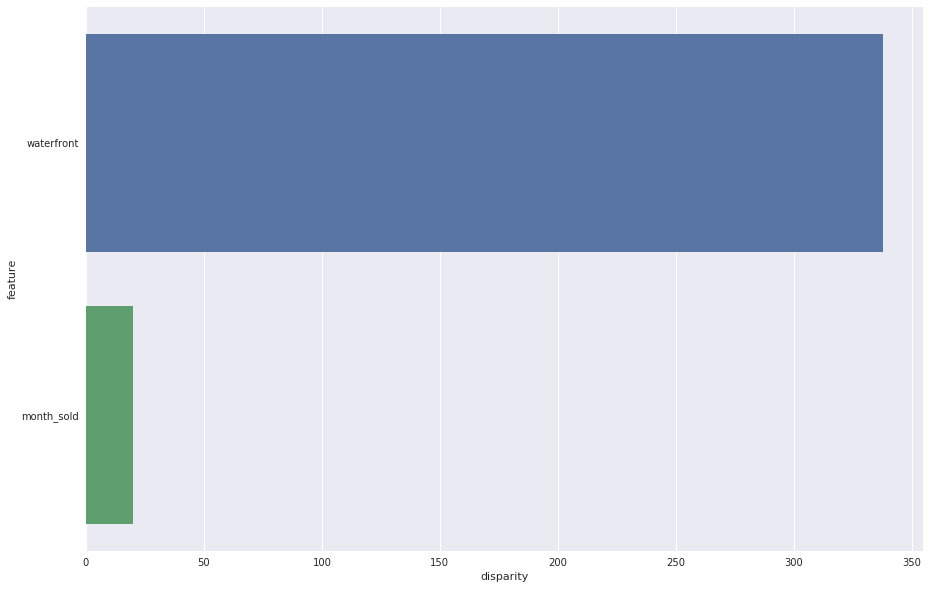

In [29]:
# perform ANOVA test 

def anova(frame, qualitative):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s.astype(np.float64))
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(full_frame.copy(True), g["object"].tolist())
a['disparity'] = np.log(1./a['pval'].values)
sns.set(rc={'figure.figsize':(15,10)})
sns.barplot(data=a, y='feature', x='disparity')

In [30]:
# perform encoding

dummies = {}

def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature] = o
    
    return ordering
    
for c in categorical:  
    dummies[c] = encode(full_frame, c)

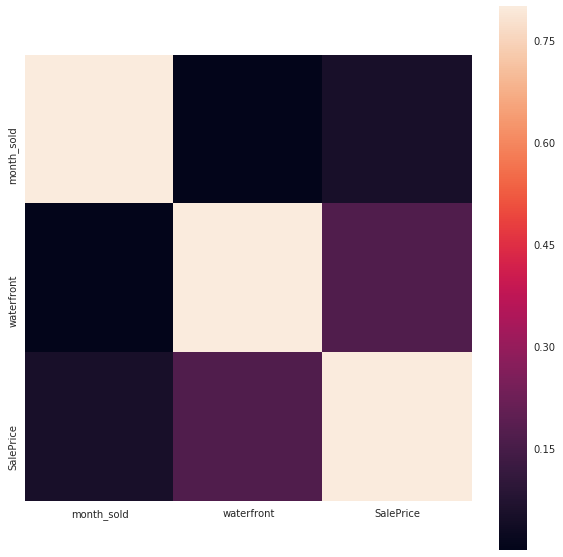

In [31]:
categorical_df = full_frame[categorical + ['SalePrice']]
categorical_df['SalePrice'] = np.log1p(categorical_df['SalePrice'])

#correlation matrix
corrmat = categorical_df.corr().abs()
cols = corrmat.sort_values(["SalePrice"])['SalePrice'].index
cm = categorical_df[cols].corr().abs()
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(cm, vmax=.8, square=True, yticklabels=cols.values, xticklabels=cols.values)

In [32]:
mask = np.ones(cm.shape,dtype='bool')
mask[np.triu_indices(len(cm))] = False

In [33]:
# dealing with features which highly correlated with each other
# features that correlated with each other more then this threshold should be considered to remove
# Please enter threshold
thresh = 0.7

In [34]:
highly_corr_cm = cm.drop(index=['SalePrice'],columns=['SalePrice'])[(cm>thresh)&mask].dropna(axis=0, how='all').dropna(axis=1, how='all')
highly_corr_cm = highly_corr_cm.append(cm['SalePrice'][highly_corr_cm.columns])
highly_corr_cm['SalePrice'] = cm['SalePrice'][highly_corr_cm.index]
highly_corr_cm

,SalePrice
SalePrice,1.0


In [35]:
# Please enter features that should be removed according to table above 
columns_to_remove = []

In [36]:
categorical_df.drop(columns=columns_to_remove, inplace=True)

Define attributes with highest correlation and transformation type which should be applied for it. Please enter wished correlation threshold for categorical values:

In [37]:
corr_threshold_for_cat_features = 0.0

In [38]:
categorical_df_log = categorical_df.copy(True)
categorical_df_log = categorical_df_log.drop(columns=['SalePrice']).apply(lambda x: np.log1p(x))
categorical_df_log["SalePrice"] = categorical_df["SalePrice"]
corrmat_log = categorical_df_log.corr().abs()

categorical_df_pow = categorical_df.copy(True)
categorical_df_pow = categorical_df_pow.drop(columns=['SalePrice']).apply(lambda x: x**2)
categorical_df_pow["SalePrice"] = categorical_df["SalePrice"]
corrmat_pow = categorical_df_pow.corr().abs()

magic_cat_table = pd.DataFrame()
magic_cat_table["log"] = corrmat_log["SalePrice"]
magic_cat_table["pow"] = corrmat_pow["SalePrice"]
magic_cat_table["origin"] = corrmat["SalePrice"]
magic_cat_table["highest_value"] = magic_cat_table.max(axis=1)

magic_cat_table["transform_type"] = "magic_cat_table"
magic_cat_table["transform_type"][magic_cat_table["log"] == magic_cat_table["highest_value"]] = "log"
magic_cat_table["transform_type"][magic_cat_table["pow"] == magic_cat_table["highest_value"]] = "pow"
magic_cat_table["transform_type"][magic_cat_table["origin"] == magic_cat_table["highest_value"]] = "origin"

magic_cat_table.drop(index=["SalePrice"], inplace=True)

magic_cat_table = magic_cat_table.sort_values('origin', ascending=False)
magic_cat_table = magic_cat_table[magic_cat_table["origin"] > corr_threshold_for_cat_features]
magic_cat_table

,log,pow,origin,highest_value,transform_type
waterfront,0.168557,0.168557,0.168557,0.168557,pow
month_sold,0.051998,0.053396,0.054110,0.054110,origin


selected categorical features

In [39]:
magic_cat_table["transform_type"]

waterfront       pow
month_sold    origin
Name: transform_type, dtype: object

### Summarize

In [40]:
magic_table = pd.concat([magic_cat_table, magic_num_table]).sort_values('origin', ascending=False)
magic_table

,log,pow,origin,highest_value,transform_type
grade,0.691795,0.703556,0.703634,0.703634,origin
sqft_living,0.674913,0.631712,0.695341,0.695341,origin
sqft_living15,0.607187,0.602142,0.619312,0.619312,origin
sqft_above,0.586303,0.568179,0.601802,0.601802,origin
bathrooms,0.520172,0.544671,0.550802,0.550802,origin
lat,0.449470,0.448876,0.449174,0.449470,log
view,0.332525,0.332772,0.346522,0.346522,origin
bedrooms,0.342927,0.229390,0.343561,0.343561,origin
sqft_basement,0.236435,0.322878,0.316970,0.322878,pow
floors,0.322956,0.286200,0.310558,0.322956,log


## Transformation proofs

In [41]:
if applyLogTransformForSalePrice:
    full_frame['SalePrice'] = np.expm1(full_frame['SalePrice'])
features = magic_table.index.tolist()

### Logarifm transformations

In [42]:
logarifm_frame = full_frame[features + ['SalePrice']].copy(True)
for feature in logarifm_frame.columns:
    logarifm_frame[feature] = logarifm_frame[feature].apply(lambda x: 0 if x <= 1 else np.log(x))

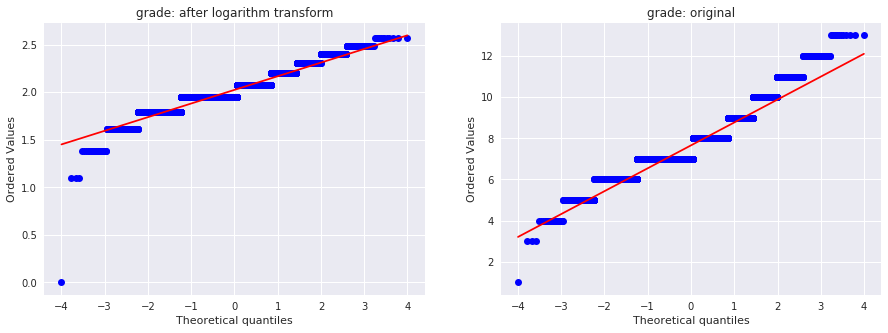

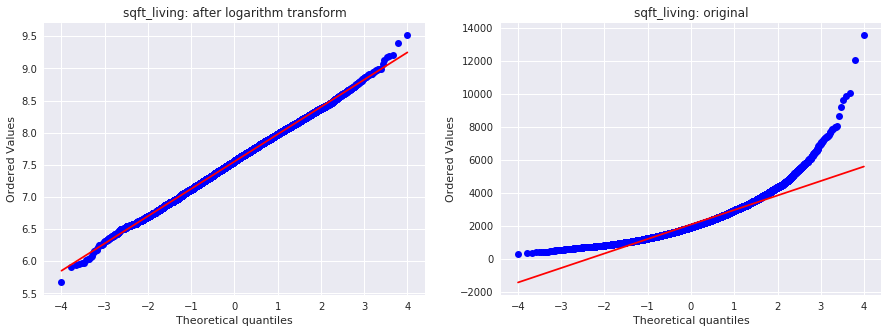

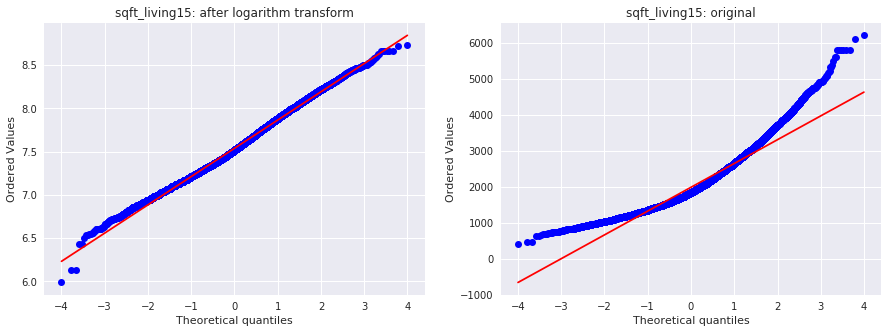

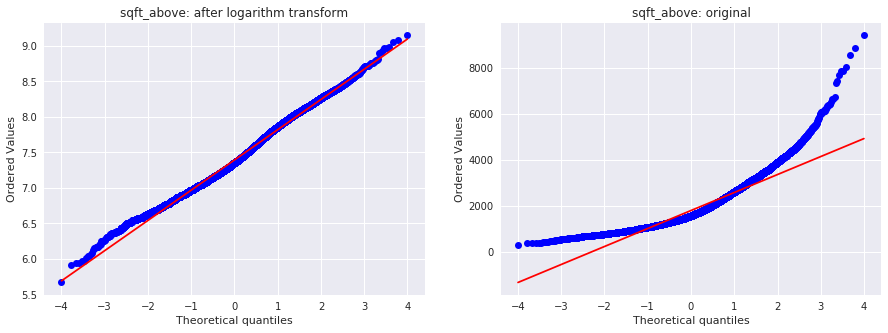

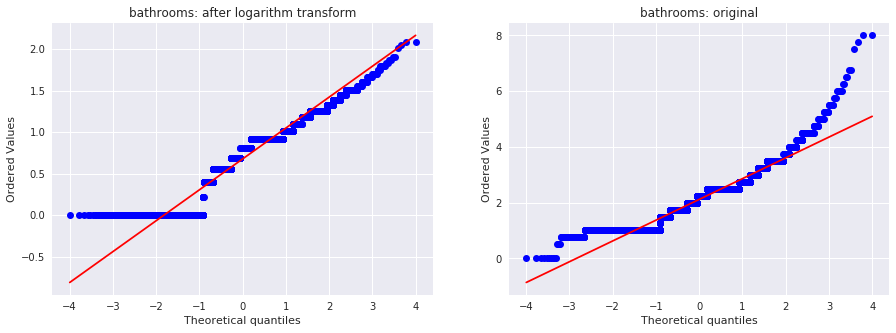

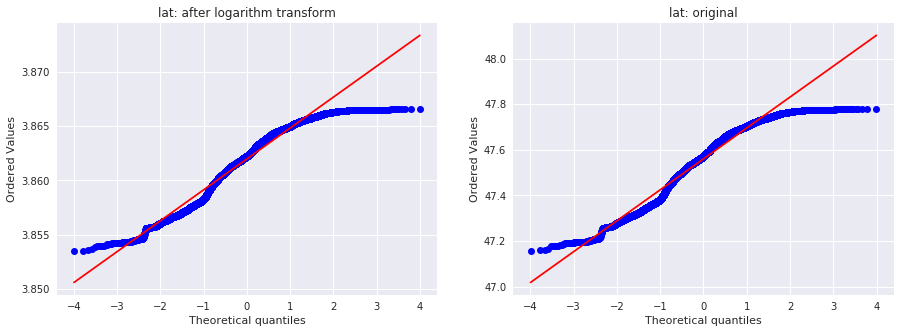

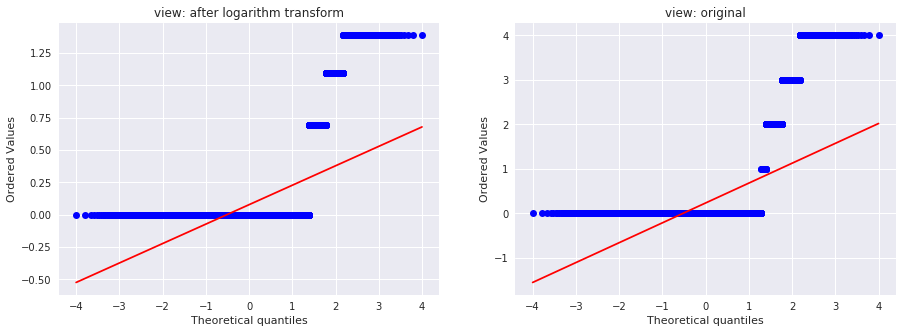

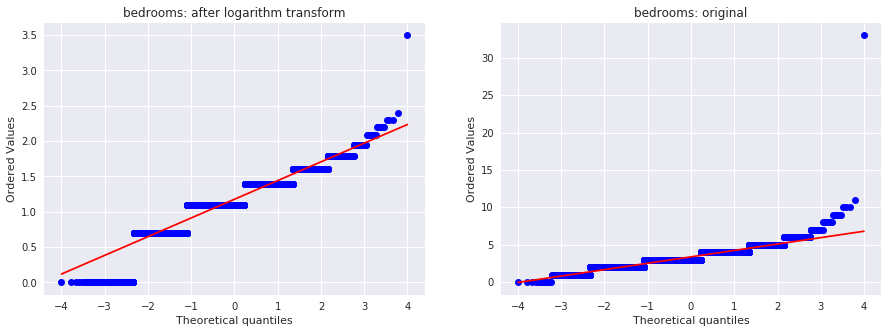

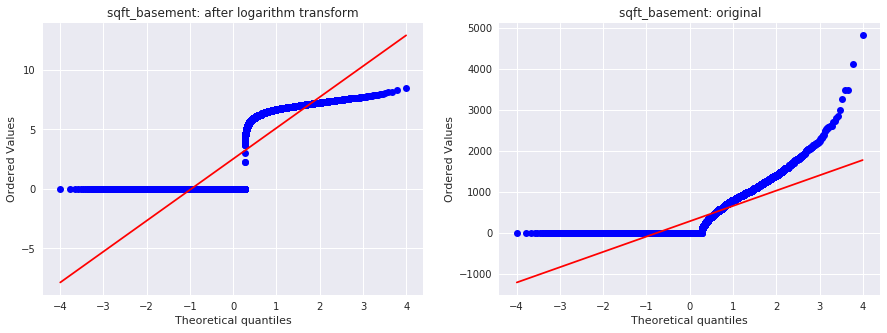

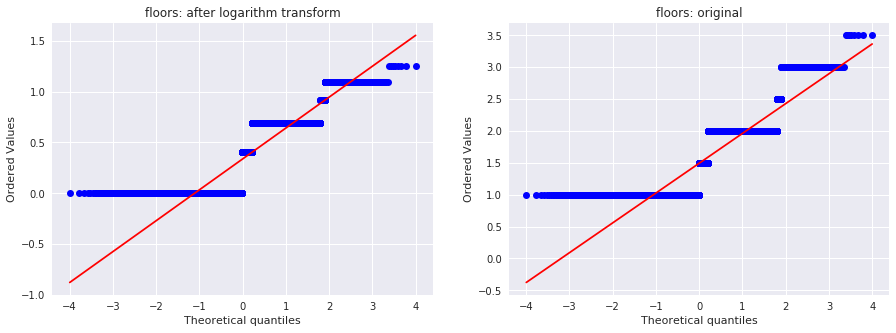

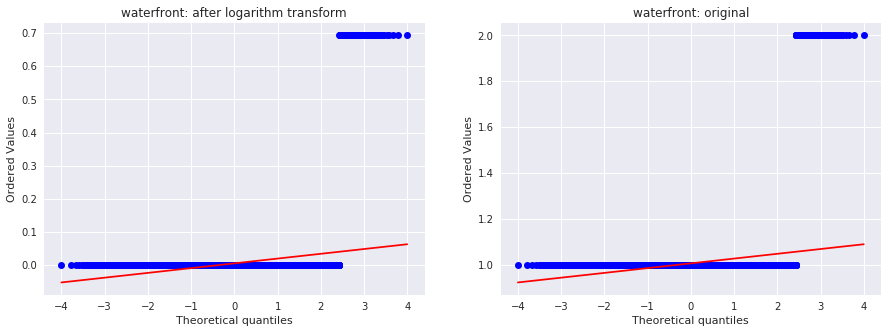

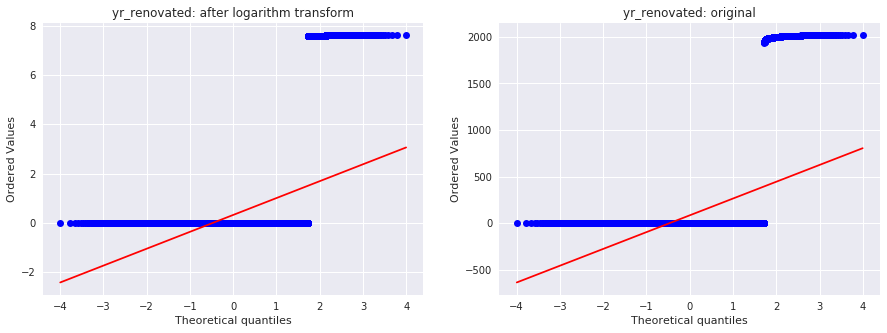

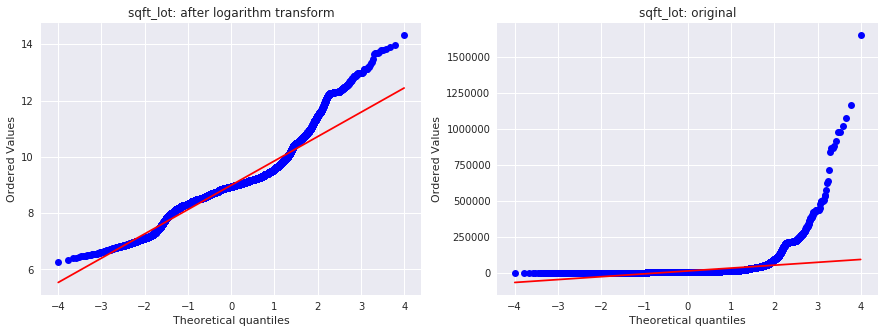

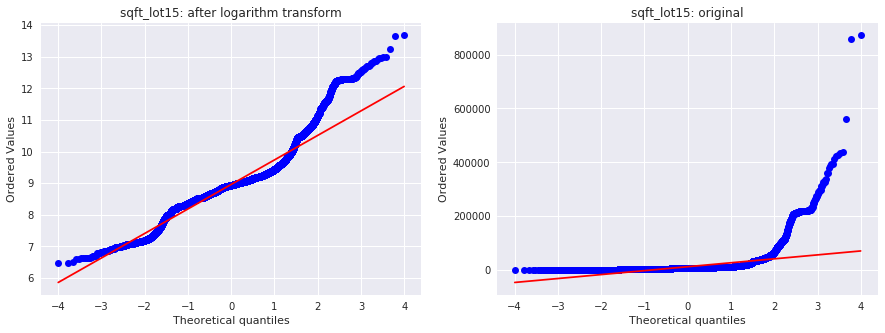

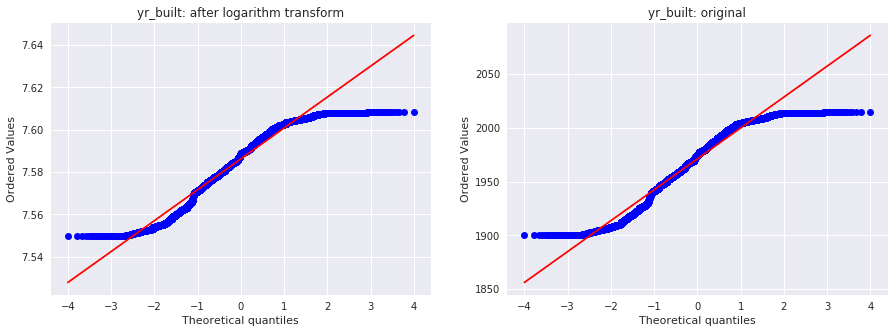

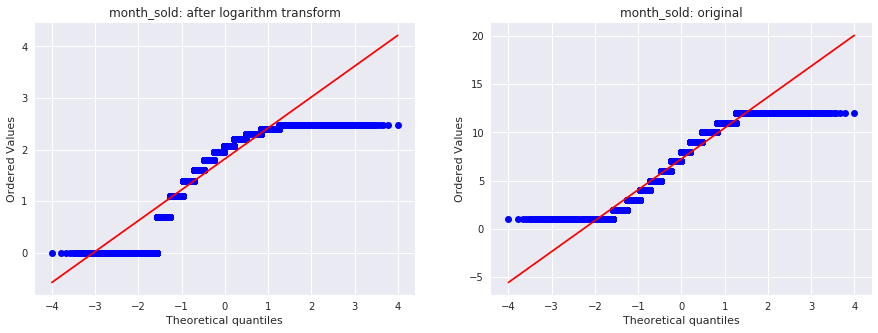

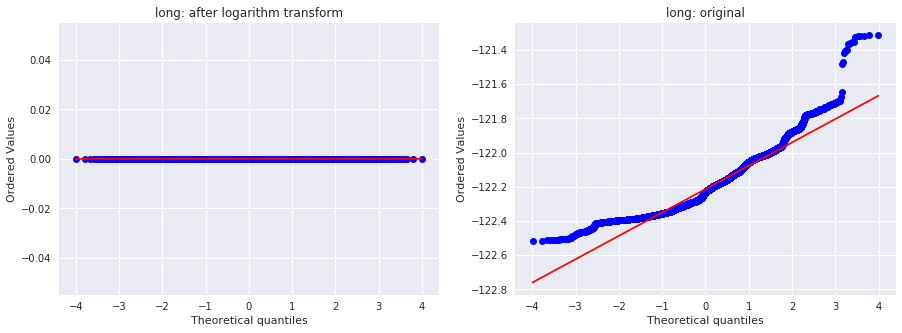

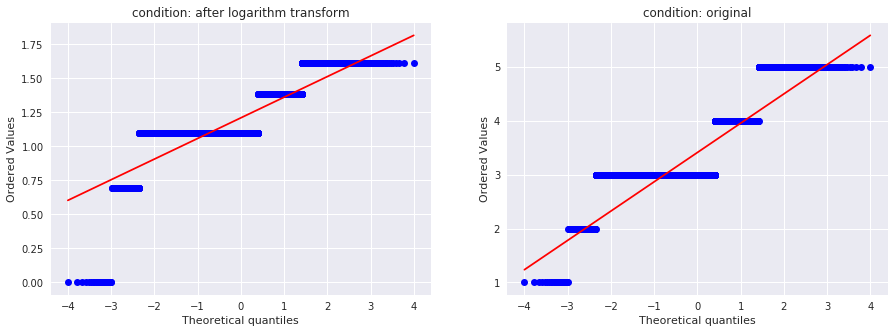

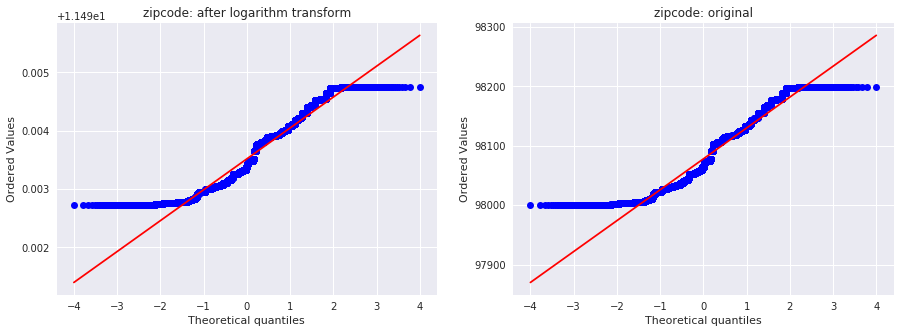

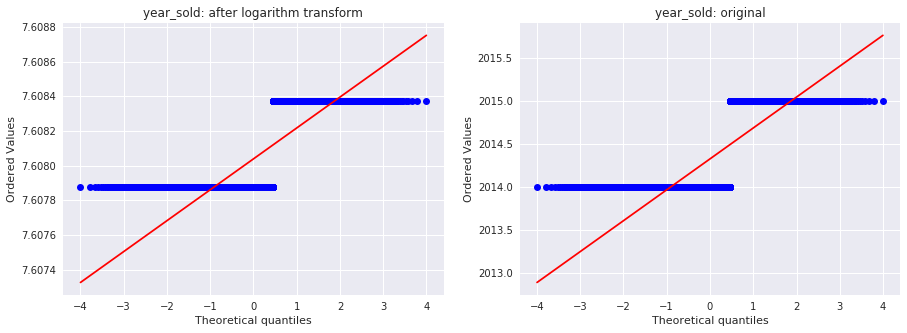

In [43]:
sns.set(rc={'figure.figsize':(15,5)})
for feature in features:
    plt.figure()
    fig, ax = plt.subplots(1,2)
    stats.probplot(logarifm_frame[feature], plot=ax[0])
    stats.probplot(full_frame[feature], plot=ax[1])
    ax[0].set_title(feature + ": after logarithm transform")
    ax[1].set_title(feature + ": original")
    plt.show()

### Pow transformations

In [44]:
pow_frame = full_frame[features + ['SalePrice']].copy(True)
for feature in logarifm_frame.columns:
    pow_frame[feature] = pow_frame[feature].apply(lambda row: row**2)

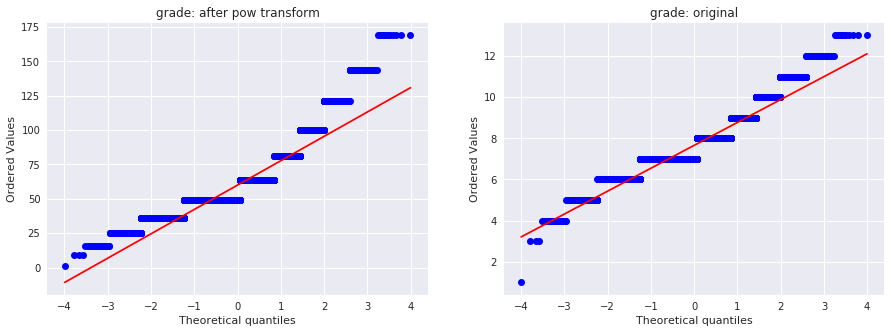

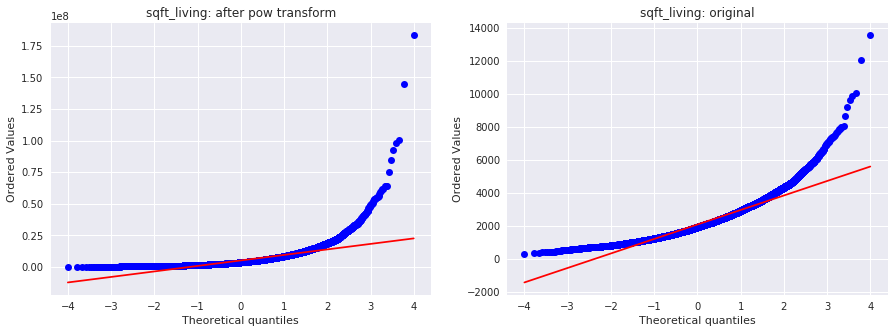

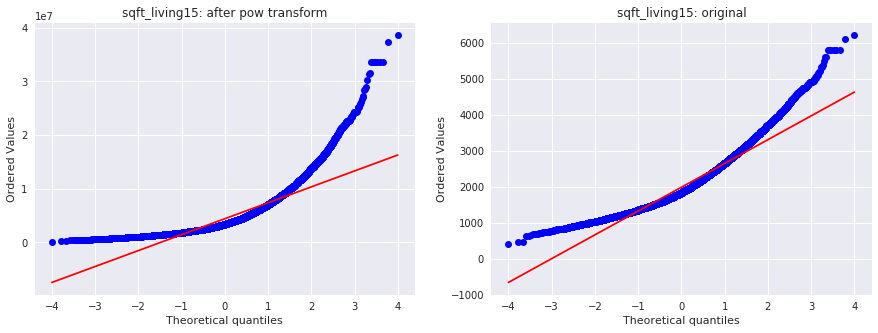

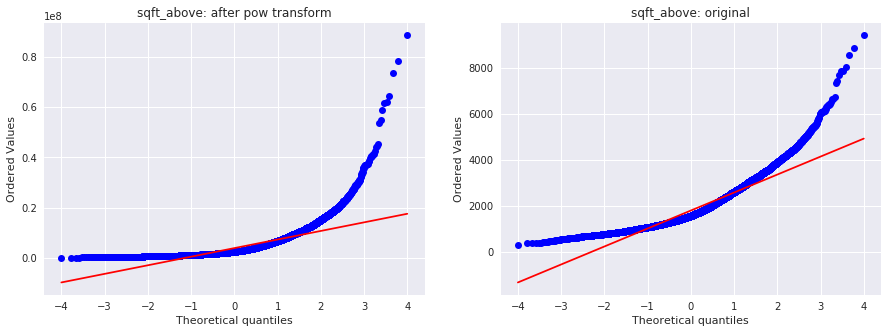

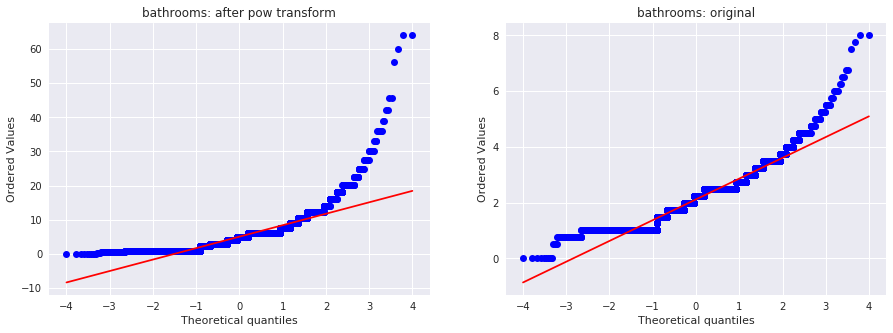

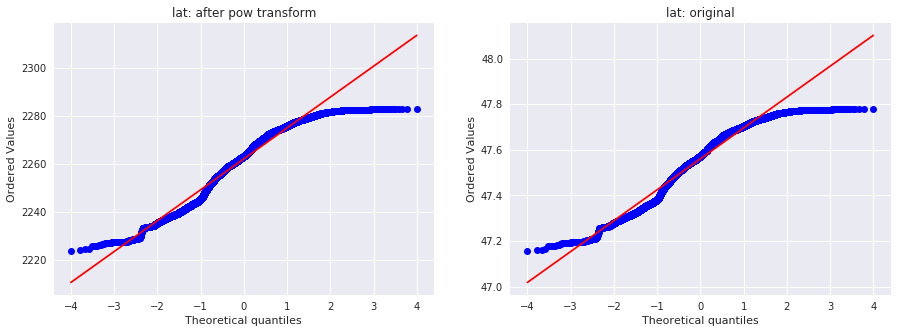

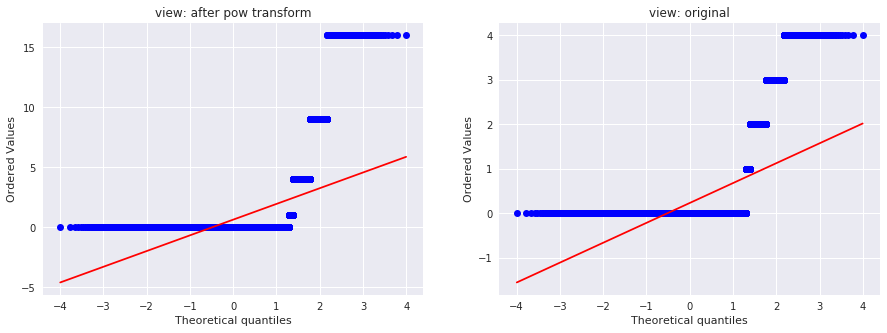

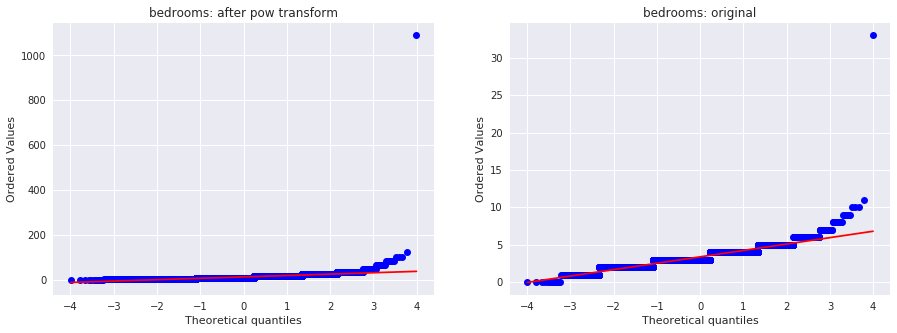

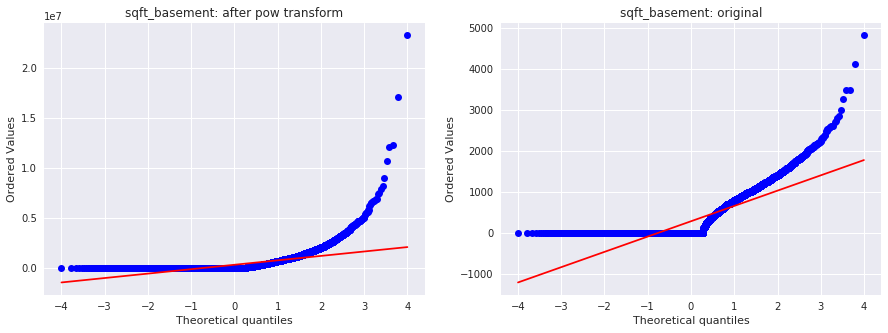

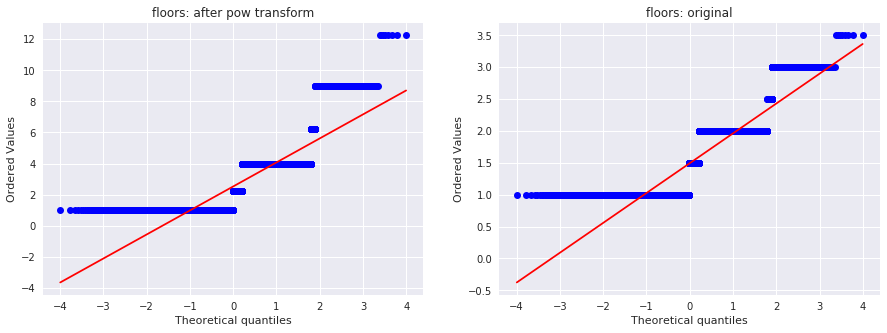

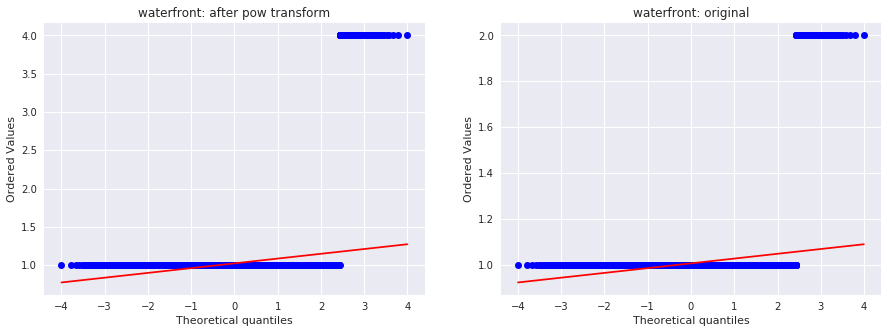

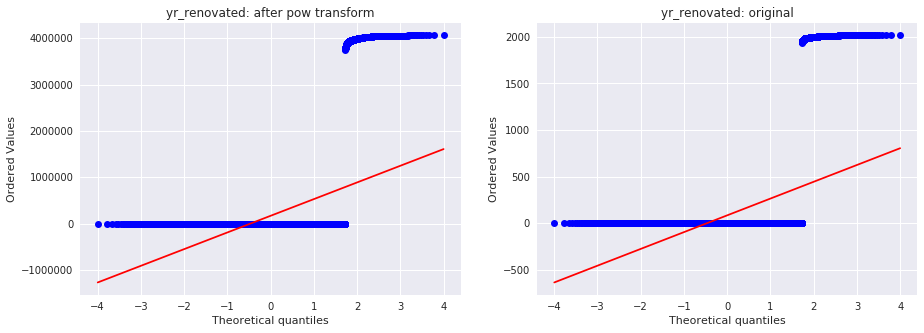

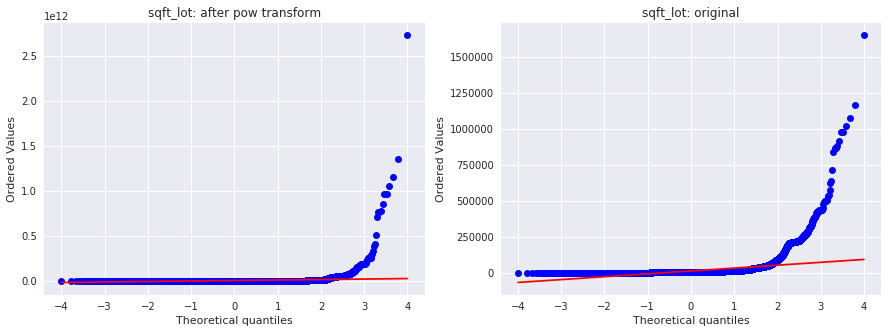

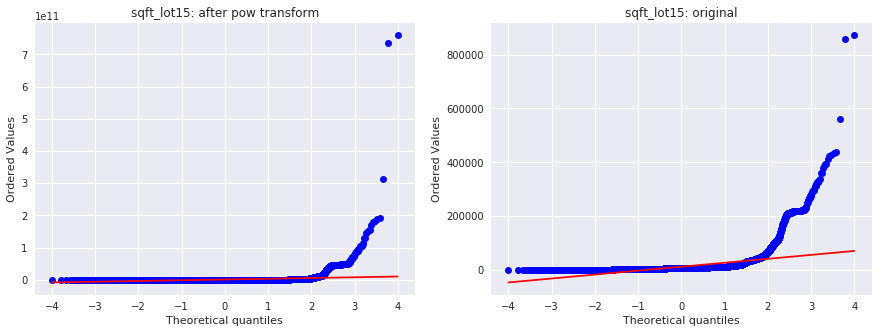

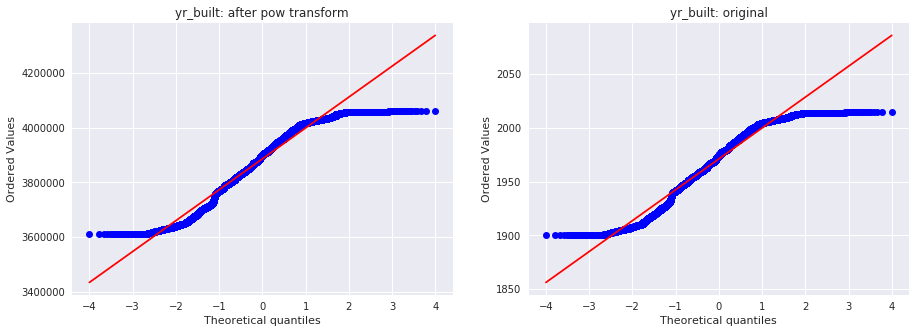

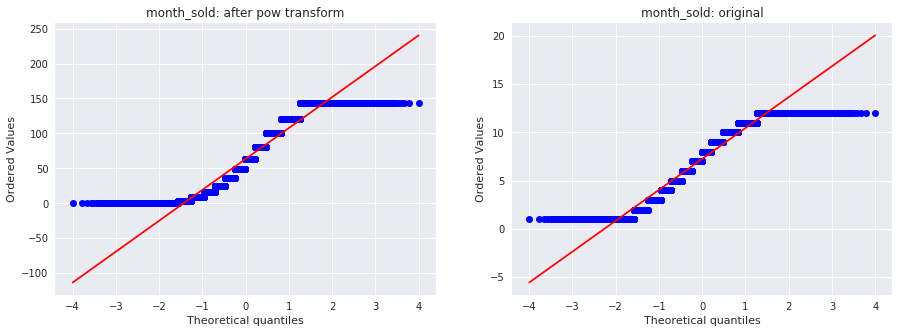

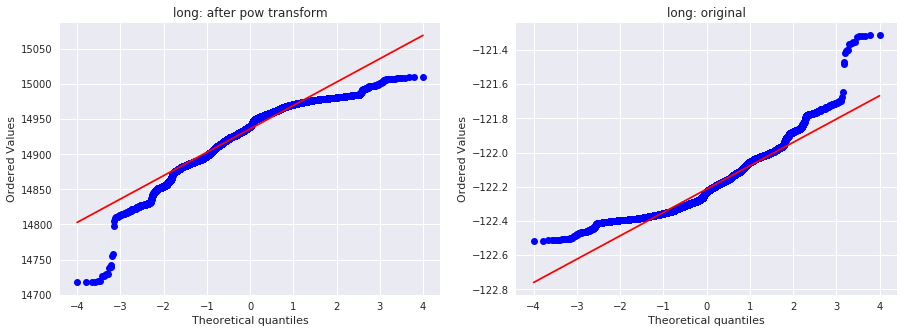

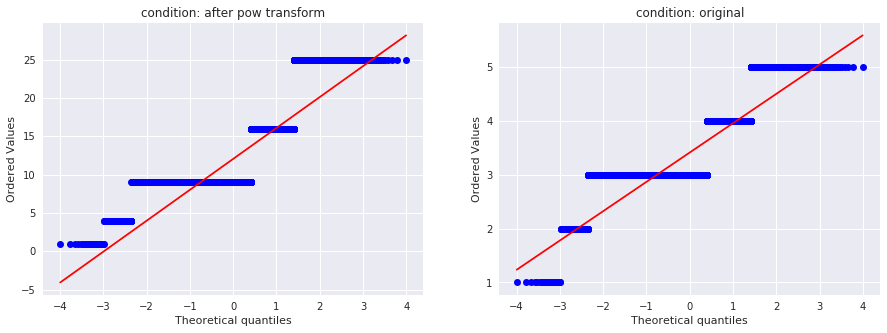

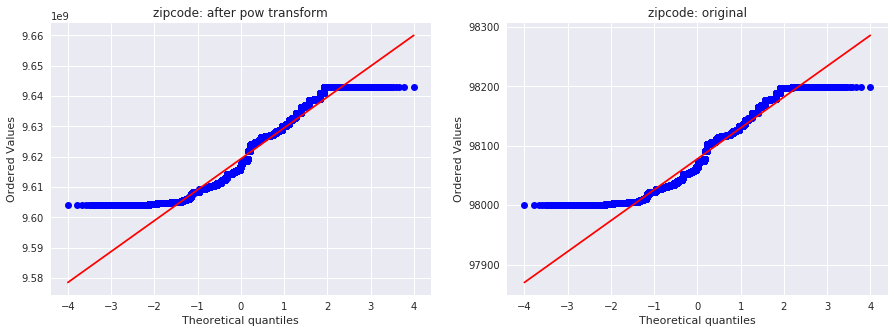

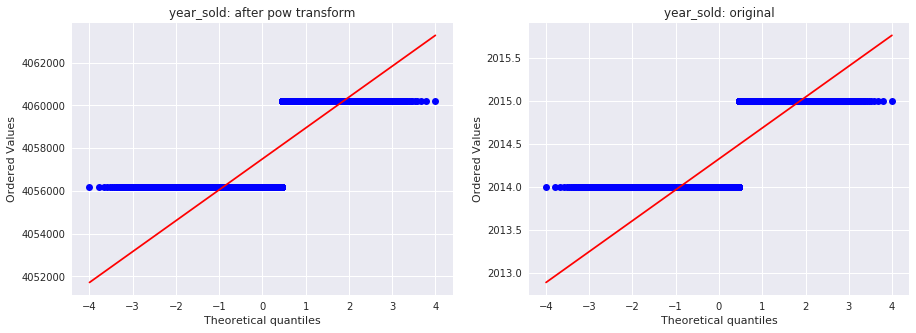

In [45]:
sns.set(rc={'figure.figsize':(15,5)})
for feature in features:
    plt.figure()
    fig, ax = plt.subplots(1,2)
    stats.probplot(pow_frame[feature], plot=ax[0])
    stats.probplot(full_frame[feature], plot=ax[1])
    ax[0].set_title(feature + ": after pow transform")
    ax[1].set_title(feature + ": original")
    plt.show()

### Save results for future learning

In [46]:
notebook_collection = db["notebook"]
notebook_collection.remove({})
notebook_collection.insert_many(full_frame.to_dict('records'))